In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp; from scipy.io import wavfile; from scipy import signal
import pydub
from pydub import AudioSegment

The sampling rate of the audio files.

In [2]:
sr = 44100

Little function used to write to audio files.

In [3]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# Get Data

In [4]:
df_a = pd.read_pickle("./acoustic_df.pkl")

In [5]:
E = np.array(df_a['E'].dropna()); Em = np.array(df_a['E_mute'].dropna()); 
A = np.array(df_a['A'].dropna()); Am = np.array(df_a['A_mute'].dropna()); 
D = np.array(df_a['D'].dropna()); Dm = np.array(df_a['D_mute'].dropna()); 
G = np.array(df_a['G'].dropna()); Gm = np.array(df_a['G_mute'].dropna()); 
B = np.array(df_a['B'].dropna()); Bm = np.array(df_a['B_mute'].dropna()); 
Eh = np.array(df_a['Eh'].dropna()); Ehm = np.array(df_a['Eh_mute'].dropna()); 

# Sampling Experiment

Apply a few filters to the time series of the form

$$L[X_t] = \sum_{u=-\infty}^\infty g_u X_{t-u} $$

In [7]:
def remove_mean(arr):
    return np.mean(arr), arr-np.mean(arr)

In [35]:
def apply_filt(arr, g):
    
    new_arr = np.empty(shape=len(arr))
    seq_len = len(g)
    
    for (i, a_i) in enumerate(arr):
        for(j, g_j) in enumerate(g):
            if i-j<0:
                break
            new_arr[i] += g_j*arr[i-j]
    return new_arr

In [55]:
E_mean, E_d = remove_mean(E)
write('modified_sounds/ac_E_demean.mp3', sr, E_d, normalized=False)

## Autoregressive Filter

Define the autoregressive transfer function

In [62]:
g_auto1 = np.array([np.e**(-(t/50)) for t in range(100)])
g_auto1 = g_auto1/np.sum(g_auto1)

g_auto2 = np.array([np.e**(-(t/200)) for t in range(200)])
g_auto2 = g_auto2/np.sum(g_auto2)

Plot the transfer functions

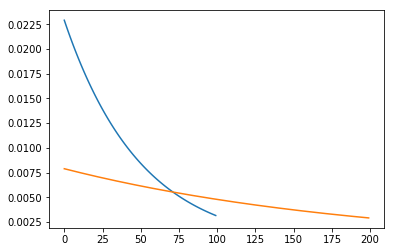

In [63]:
plt.plot(g_auto1)
plt.plot(g_auto2)

Apply the filter

In [64]:
E_autoreg1 = apply_filt(E, g_auto1)
E_autoreg2 = apply_filt(E, g_auto2)
write('modified_sounds/ac_E_autoreg1.mp3', sr, E_autoreg1, normalized=False)
write('modified_sounds/ac_E_autoreg2.mp3', sr, E_autoreg2, normalized=False)

Plot the filtered signal

(0, 10000)

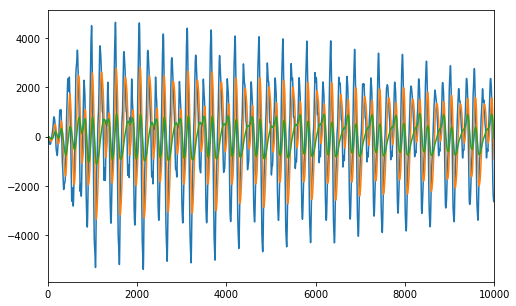

In [65]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(E_d)
ax.plot(E_autoreg1)
ax.plot(E_autoreg2)

ax.set_xlim(0,10000)

Compute periodogram

In [68]:
f_E, Pxx_den_E_d = signal.periodogram(E_d, sr)
f_E_autoreg1, Pxx_den_E_autoreg1 = signal.periodogram(E_autoreg1, sr)
f_E_autoreg2, Pxx_den_E_autoreg2 = signal.periodogram(E_autoreg2, sr)

Plot periodogram

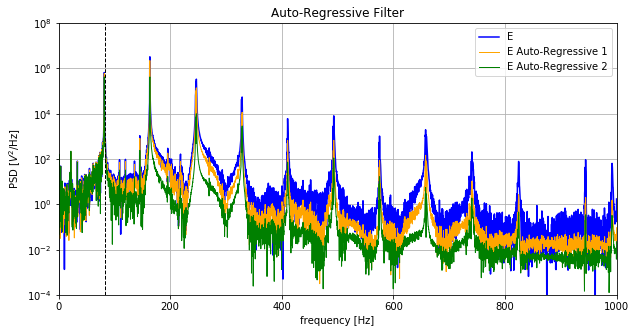

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E_d, label='E', c='blue')
ax.semilogy(f_E_autoreg1, Pxx_den_E_autoreg1, label='E Auto-Regressive 1', lw=1, c='Orange')
ax.semilogy(f_E_autoreg2, Pxx_den_E_autoreg2, label='E Auto-Regressive 2', lw=1, c='Green')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()
ax.set_title('Auto-Regressive Filter')

# Main Frequencies of a Guitar in Tune
ax.axvline(82.4, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()

## Least Squares Filter

Define the least squares function (see pg 176-177)

In [124]:
def g_UI(u, W):
    if u==0:
        return 2*W
    else:
        return np.sin(2*np.pi*W*u)/(np.pi*u)

We want to cut off all harmonics higher than the second.

In [137]:
K=500; W=200/sr
g_lsq1 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])

K=500; W=100/sr
g_lsq2 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])

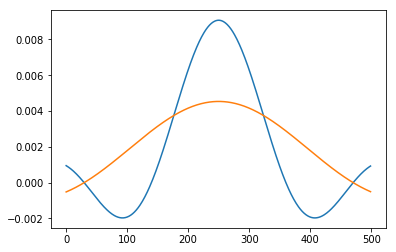

In [142]:
plt.plot(g_lsq1)
plt.plot(g_lsq2)

Apply filter

In [138]:
E_lsq1 = apply_filt(E, g_lsq1)
E_lsq2 = apply_filt(E, g_lsq2)
write('modified_sounds/ac_E_lsq1.mp3', sr, E_lsq1, normalized=False)
write('modified_sounds/ac_E_lsq2.mp3', sr, E_lsq2, normalized=False)

Compute periodogram

In [140]:
f_E_lsq1, Pxx_den_E_lsq1 = signal.periodogram(E_lsq1, sr)
f_E_lsq2, Pxx_den_E_lsq2 = signal.periodogram(E_lsq2, sr)

Plot

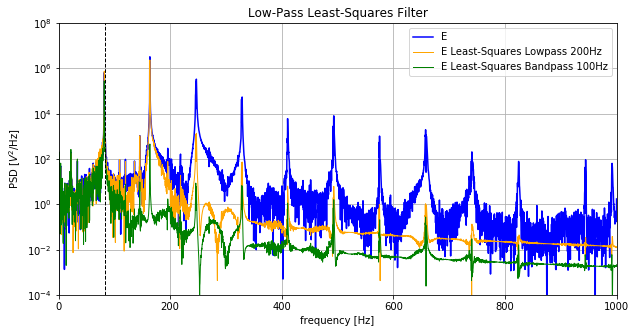

In [143]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E_d, label='E', c='blue')
ax.semilogy(f_E_lsq1, Pxx_den_E_lsq1, label='E Least-Squares Lowpass 200Hz', lw=1, c='Orange')
ax.semilogy(f_E_lsq2, Pxx_den_E_lsq2, label='E Least-Squares Bandpass 100Hz', lw=1, c='Green')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()
ax.set_title('Low-Pass Least-Squares Filter')

# Main Frequencies of a Guitar in Tune
ax.axvline(82.4, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()